In [12]:
from sklearn.datasets import load_breast_cancer, load_wine
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import f1_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt

from votingclassifier import VotingClassifier
from adaboost import AdaBoost

In [13]:
glass = pd.read_csv('../NBayes/data/glass.data')
glass.drop('id', axis=1, inplace=True)
glass.head(2)

ri     na    mg    al     si     k    ca   ba   fe  class
0  1.52101  13.64  4.49  1.10  71.78  0.06  8.75  0.0  0.0      1
1  1.51761  13.89  3.60  1.36  72.73  0.48  7.83  0.0  0.0      1

In [14]:
diabetes = pd.read_csv('../NBayes/data/pima-indians-diabetes.csv', skiprows=9)
diabetes.head(2)

times_pregnant  plasma  blood_pressure  skin_thickness  insulin  mass_idx  \
0               6     148              72              35        0      33.6   
1               1      85              66              29        0      26.6   

   pedigree  age  class  
0     0.627   50      1  
1     0.351   31      0

In [15]:
wine_data = load_wine()
wine = pd.DataFrame(wine_data.data, columns=wine_data.feature_names)
wine['class'] = wine_data.target
display(wine.head(2))

alcohol  malic_acid   ash  alcalinity_of_ash  magnesium  total_phenols  \
0    14.23        1.71  2.43               15.6      127.0           2.80   
1    13.20        1.78  2.14               11.2      100.0           2.65   

   flavanoids  nonflavanoid_phenols  proanthocyanins  color_intensity   hue  \
0        3.06                  0.28             2.29             5.64  1.04   
1        2.76                  0.26             1.28             4.38  1.05   

   od280/od315_of_diluted_wines  proline  class  
0                          3.92   1065.0      0  
1                          3.40   1050.0      0

In [16]:
cancer_data = load_breast_cancer()
cancer = pd.DataFrame(cancer_data.data, columns=cancer_data.feature_names)
cancer['class'] = cancer_data.target
cancer.head(2)

mean radius  mean texture  mean perimeter  mean area  mean smoothness  \
0        17.99         10.38           122.8     1001.0          0.11840   
1        20.57         17.77           132.9     1326.0          0.08474   

   mean compactness  mean concavity  mean concave points  mean symmetry  \
0           0.27760          0.3001              0.14710         0.2419   
1           0.07864          0.0869              0.07017         0.1812   

   mean fractal dimension  ...    worst texture  worst perimeter  worst area  \
0                 0.07871  ...            17.33            184.6      2019.0   
1                 0.05667  ...            23.41            158.8      1956.0   

   worst smoothness  worst compactness  worst concavity  worst concave points  \
0            0.1622             0.6656           0.7119                0.2654   
1            0.1238             0.1866           0.2416                0.1860   

   worst symmetry  worst fractal dimension  class  
0          0.4601                  0.11890      0  
1          0.2750                  0.08902      0  

[2 rows x 31 columns]

In [17]:
def plot_heights_over_bars(ax):
    for p in ax.patches:
        height = p.get_height()
        ax.text(p.get_x()  + p.get_width() / 2.,
                height + .01,
                '{:1.2f}'.format(height),
                ha='center',
                fontsize=9) 

In [18]:
datasets = [('glass', glass), ('diabetes', diabetes), ('wine', wine), ('cancer', cancer)]


In [19]:
def get_score_for_split(split, X, y):
    train_index, test_index = split
    
    X_train, X_test = X.loc[train_index], X.loc[test_index]
    y_train, y_test = y.loc[train_index], y.loc[test_index]

    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)

    return f1_score(y_test, y_pred, average='micro')

In [20]:
from multiprocessing import Pool
from functools import partial

def stratified_cv(n_splits, ds):
    skf = StratifiedKFold(n_splits=5)

    X = ds.drop('class', axis=1)
    y = ds['class']

    fscores = []
    
    splits = skf.split(X, y)
    
    with Pool() as pool:
        fscores = pool.map(partial(get_score_for_split, X=X, y=y), splits)
        
    return fscores
    

In [21]:
sns.set(style='whitegrid')

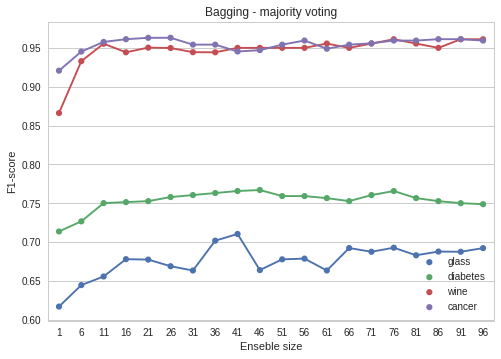

In [22]:
n_splits = 5

ensemble_sizes = range(1, 100, 5)

results = {
    'scores': [],
    'dataset_names': [],
    'ensemble_size': []
}

for size in ensemble_sizes:
    classifiers = [DecisionTreeClassifier() for _ in range(size)]
    clf = VotingClassifier(classifiers, weighted_voting=False, randomize_training_sets=True, k_out=0)

    for name, ds in datasets:
        fscores = stratified_cv(n_splits, ds)

        results['scores'].append(np.mean(fscores))
        results['dataset_names'].append(name)
        results['ensemble_size'].append(size)

ax = sns.pointplot('ensemble_size', 'scores', hue='dataset_names', data=results, scale = 0.6)
_ = ax.set_ylabel('F1-score')
_ = ax.set_xlabel('Enseble size')
_ = ax.set_title('Bagging - majority voting')

plt.savefig('images/bagging_majority_voting.pdf', format='pdf')

In [23]:
n_splits = 5

ensemble_sizes = range(1, 100, 5)

results = {
    'scores': [],
    'dataset_names': [],
    'ensemble_size': []
}

for size in ensemble_sizes:
    classifiers = [DecisionTreeClassifier() for _ in range(size)]
    clf = VotingClassifier(classifiers, weighted_voting=True, randomize_training_sets=True, k_out=0)

    for name, ds in datasets:
        fscores = stratified_cv(n_splits, ds)

        results['scores'].append(np.mean(fscores))
        results['dataset_names'].append(name)
        results['ensemble_size'].append(size)

ax = sns.pointplot('ensemble_size', 'scores', hue='dataset_names', data=results, scale = 0.6)
_ = ax.set_ylabel('F1-score')
_ = ax.set_xlabel('Enseble size')
_ = ax.set_title('Bagging - weighted voting')

plt.savefig('images/bagging_weighted_voting.pdf', format='pdf')

Process ForkPoolWorker-458:
Process ForkPoolWorker-457:
Traceback (most recent call last):
Traceback (most recent call last):
Process ForkPoolWorker-459:
  File "/opt/conda/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/opt/conda/lib/python3.6/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/opt/conda/lib/python3.6/multiprocessing/pool.py", line 119, in worker
    result = (True, func(*args, **kwds))
  File "/opt/conda/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "<ipython-input-19-25f9cb597db2>", line 7, in get_score_for_split
    clf.fit(X_train, y_train)
Process ForkPoolWorker-460:
  File "/opt/conda/lib/python3.6/multiprocessing/pool.py", line 44, in mapstar
    return list(map(*args))
  File "/opt/conda/lib/python3.6/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
Traceback (most recent call last):
  F

KeyboardInterrupt: 

In [ ]:
n_splits = 5

ensemble_sizes = range(1, 100, 5)

results = {
    'scores': [],
    'dataset_names': [],
    'ensemble_size': []
}

for size in ensemble_sizes:
    clf = AdaBoost(DecisionTreeClassifier(), n_cls=size)

    for name, ds in datasets:
        fscores = stratified_cv(n_splits, ds)

        results['scores'].append(np.mean(fscores))
        results['dataset_names'].append(name)
        results['ensemble_size'].append(size)

ax = sns.pointplot('ensemble_size', 'scores', hue='dataset_names', data=results, scale = 0.6)
_ = ax.set_ylabel('F1-score')
_ = ax.set_xlabel('Enseble size')
_ = ax.set_title('AdaBoost')

plt.savefig('images/adaboost.pdf', format='pdf')

In [ ]:
n_splits = 5

ensemble_sizes = range(1, 100, 5)

results = {
    'scores': [],
    'dataset_names': [],
    'ensemble_size': []
}

for size in ensemble_sizes:
    clf = RandomForestClassifier(n_estimators=size)

    for name, ds in datasets:
        fscores = stratified_cv(n_splits, ds)

        results['scores'].append(np.mean(fscores))
        results['dataset_names'].append(name)
        results['ensemble_size'].append(size)

ax = sns.pointplot('ensemble_size', 'scores', hue='dataset_names', data=results, scale = 0.6)
_ = ax.set_ylabel('F1-score')
_ = ax.set_xlabel('Enseble size')
_ = ax.set_title('Random Forest')

plt.savefig('images/random_forest.pdf', format='pdf')

In [ ]:
def normalize_dataset(frame):
    df = frame.drop('class', axis=1)
    normalized_df = (frame - frame.mean()) / frame.std()
    normalized_df['class'] = frame['class']
    
    return normalized_df

In [ ]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB, MultinomialNB
from sklearn.neighbors import KNeighborsClassifier

classifiers = [DecisionTreeClassifier() for _ in range(100)]
v_clf = VotingClassifier(classifiers, weighted_voting=False, randomize_training_sets=True, k_out=0)

classifiers = [GaussianNB(), MultinomialNB(), DecisionTreeClassifier(), KNeighborsClassifier(), v_clf, AdaBoost(DecisionTreeClassifier(), n_cls=100), RandomForestClassifier(100)]

results = {
    'scorings': [],
    'classifiers': [],
    'dataset_names': []
}

for clf in classifiers:
    for name, ds in datasets:
        if clf.__class__.__name__ == 'KNeighborsClassifier':
            ds = normalize_dataset(ds)
            
        scores = cross_val_score(clf, ds.drop('class', axis=1), ds['class'], scoring='f1_micro', cv=5)

        results['classifiers'].append(clf.__class__.__name__)
        results['scorings'].append(np.mean(scores))
        results['dataset_names'].append(name)

display(pd.DataFrame.from_dict(results).head())

In [ ]:
fig, ax = plt.subplots(figsize=(10, 6))

ax = sns.barplot('dataset_names', 'scorings', hue='classifiers', data=results, ax = ax)
ax.set_xlabel('Datasets')
ax.set_ylabel('F1-score')

ax.set_ylim(0.2, 1)

plot_heights_over_bars(ax)

plt.savefig('images/comparison.pdf', format='pdf')

## TODO

- bootstrap T/F
- max_samples

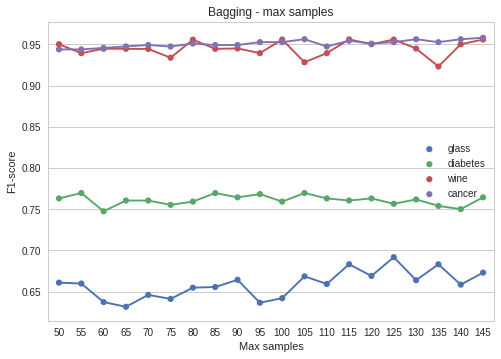

In [27]:
max_samples_sizes = range(50, 150, 5)
n_splits = 5

results = {
    'scores': [],
    'dataset_names': [],
    'max_samples': []
}

for max_samples in max_samples_sizes:
    classifiers = [DecisionTreeClassifier() for _ in range(40)]
    clf = VotingClassifier(classifiers, weighted_voting=False, randomize_training_sets=True, max_samples=max_samples)

    for name, ds in datasets:
        fscores = stratified_cv(n_splits, ds)

        results['scores'].append(np.mean(fscores))
        results['dataset_names'].append(name)
        results['max_samples'].append(max_samples)

ax = sns.pointplot('max_samples', 'scores', hue='dataset_names', data=results, scale = 0.6)
_ = ax.set_ylabel('F1-score')
_ = ax.set_xlabel('Max samples')
_ = ax.set_title('Bagging - max samples')

plt.savefig('images/bagging_max_samples.pdf', format='pdf')

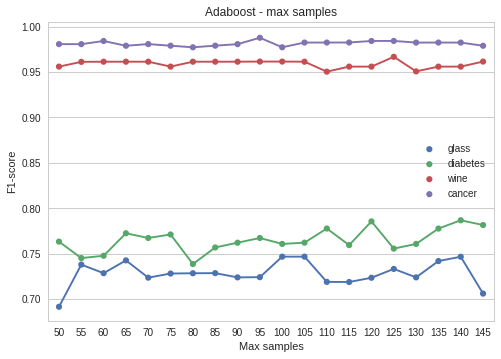

In [28]:
results = {
    'scores': [],
    'dataset_names': [],
    'max_samples': []
}

for max_samples in max_samples_sizes:
    clf = AdaBoost(DecisionTreeClassifier(), n_cls=100, max_samples=max_samples)

    for name, ds in datasets:
        fscores = stratified_cv(n_splits, ds)

        results['scores'].append(np.mean(fscores))
        results['dataset_names'].append(name)
        results['max_samples'].append(max_samples)

ax = sns.pointplot('max_samples', 'scores', hue='dataset_names', data=results, scale = 0.6)
_ = ax.set_ylabel('F1-score')
_ = ax.set_xlabel('Max samples')
_ = ax.set_title('Adaboost - max samples')

plt.savefig('images/adaboost_max_samples.pdf', format='pdf')

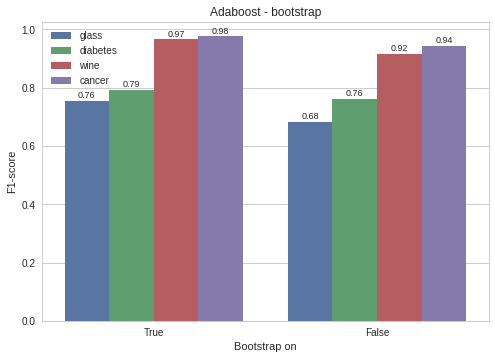

In [33]:
results = {
    'scores': [],
    'dataset_names': [],
    'bootstrap': []
}

for bootstrap in [True, False]:
    clf = AdaBoost(DecisionTreeClassifier(), n_cls=100, bootstrap=bootstrap)

    for name, ds in datasets:
        fscores = stratified_cv(n_splits, ds)

        results['scores'].append(np.mean(fscores))
        results['dataset_names'].append(name)
        results['bootstrap'].append(str(bootstrap))

ax = sns.barplot('bootstrap', 'scores', hue='dataset_names', data=results)
_ = ax.set_ylabel('F1-score')
_ = ax.set_xlabel('Bootstrap on')
_ = ax.set_title('Adaboost - bootstrap')

plot_heights_over_bars(ax)

plt.savefig('images/adaboost_bootstrap.pdf', format='pdf')

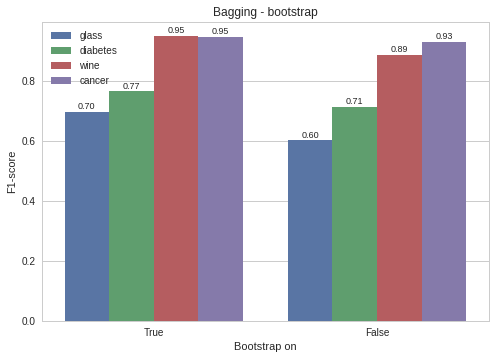

In [35]:
results = {
    'scores': [],
    'dataset_names': [],
    'bootstrap': []
}

for bootstrap in [True, False]:
    classifiers = [DecisionTreeClassifier() for _ in range(40)]
    clf = VotingClassifier(classifiers, weighted_voting=False, randomize_training_sets=True, bootstrap=bootstrap)

    for name, ds in datasets:
        fscores = stratified_cv(n_splits, ds)

        results['scores'].append(np.mean(fscores))
        results['dataset_names'].append(name)
        results['bootstrap'].append(str(bootstrap))

ax = sns.barplot('bootstrap', 'scores', hue='dataset_names', data=results)
_ = ax.set_ylabel('F1-score')
_ = ax.set_xlabel('Bootstrap on')
_ = ax.set_title('Bagging - bootstrap')

plot_heights_over_bars(ax)

plt.savefig('images/bagging_bootstrap.pdf', format='pdf')

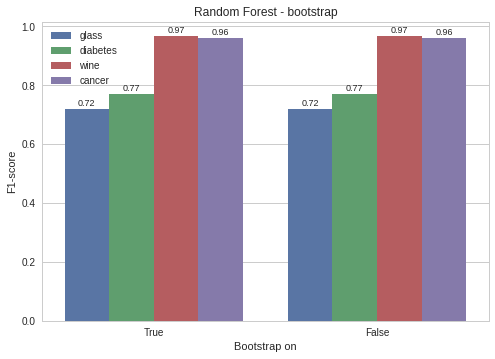

In [36]:
results = {
    'scores': [],
    'dataset_names': [],
    'bootstrap': []
}

for bootstrap in [True, False]:
    clf = RandomForestClassifier(100)

    for name, ds in datasets:
        fscores = stratified_cv(n_splits, ds)

        results['scores'].append(np.mean(fscores))
        results['dataset_names'].append(name)
        results['bootstrap'].append(str(bootstrap))

ax = sns.barplot('bootstrap', 'scores', hue='dataset_names', data=results)
_ = ax.set_ylabel('F1-score')
_ = ax.set_xlabel('Bootstrap on')
_ = ax.set_title('Random Forest - bootstrap')

plot_heights_over_bars(ax)

plt.savefig('images/random_forest_bootstrap.pdf', format='pdf')

Additional measure for RF (max_features)
- If int, then consider max_features features at each split.
- If float, then max_features is a percentage and int(max_features * n_features) features are considered at each split.
- If “auto”, then max_features=sqrt(n_features).
- If “sqrt”, then max_features=sqrt(n_features) (same as “auto”).
- If “log2”, then max_features=log2(n_features).
- If None, then max_features=n_features.


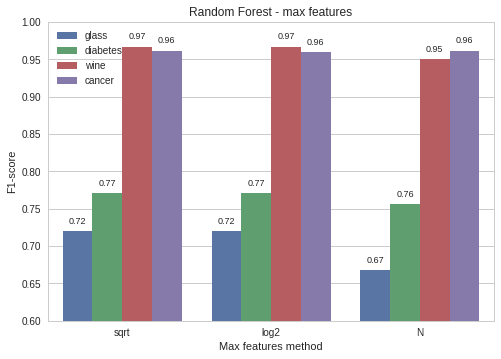

In [82]:
max_features_values = ['sqrt', 'log2', None]

results = {
    'scores': [],
    'dataset_names': [],
    'max_features': []
}

for max_f in max_features_values:
    clf = RandomForestClassifier(100, max_features=max_f)

    for name, ds in datasets:
        fscores = stratified_cv(n_splits, ds)

        results['scores'].append(np.mean(fscores))
        results['dataset_names'].append(name)
        
        if max_f == None:
            max_f = 'N'
        results['max_features'].append(str(max_f))

ax = sns.barplot('max_features', 'scores', hue='dataset_names', data=results)
_ = ax.set_ylabel('F1-score')
_ = ax.set_xlabel('Max features method')
_ = ax.set_title('Random Forest - max features')
ax.set_ylim(0.6, 1)

plot_heights_over_bars(ax)

plt.savefig('images/random_forest_max_features.pdf', format='pdf')